In [ ]:
# Copyright (c) 2023 Sophie Katz
#
# This file is part of Language Model.
#
# Language Model is free software: you can redistribute it and/or modify it under
# the terms of the GNU General Public License as published by the Free Software
# Foundation, either version 3 of the License, or (at your option) any later version.
#
# Language Model is distributed in the hope that it will be useful, but WITHOUT
# ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A
# PARTICULAR PURPOSE. See the GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License along with Language
# Model. If not, see <https://www.gnu.org/licenses/>.

# Writing positional encoding from scratch using Pytorch

This is a simple implementation of positional encoding in PyTorch.

This is based off the word embedding module from [this notebook](word_embedding_from_scratch.ipynb).

## Resources used

Name | URL
---- | ---
Detailed explanation of positional encoding | https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/
Making a transformer from scratch | https://medium.com/the-dl/transformers-from-scratch-in-pytorch-8777e346ca51

## Imports

In [21]:
import torch as T
import math
import seaborn as sns

## Constants

In [27]:
SEQUENCE_LENGTH = 100
EMBEDDING_SIZE = 512


## Encoder

Vaswani et. al. use trigonometric functions to implement positional encoding. This is to extrapolate to longer sequence lengths because they are periodic as well as unbounded to $[0, 1]$. This allows them to extrapolate to sequence lengths in inference that are much longer than in training. The formulae they use are:

$$positional\_encoding_(p, 2i) = sin(\frac{p}{10000^{2i/d}})$$
$$positional\_encoding_(p, 2i+1) = cos(\frac{p}{10000^{2i/d}})$$

Where:
* $p$ is the position of the item in the sequence
* $i$ index over the embedding vector for the item at position $p$
* $d$ is the dimension of the output embedding vector for the item at position $p$

Let's create an example encoding matrix to illustrate how this encoder looks.

In [29]:
def get_positional_encoding_at_indices(
    sequence_position: int, embedding_index: int, embedding_size: int, base: float = 1e4
) -> float:
    """
    Calculates the positional encoding at a given sequence position and embedding index.

    Parameters
    ==========
        sequence_position: int
            The position of the item in the sequence.
        embedding_index: int
            The index in the embedding vector for that item.

    Returns
    =======
        The floating point value of the positional encoding at the given sequence
        position and embedding index.
    """

    exponent = (embedding_index - (embedding_index % 2)) / embedding_size

    phase = sequence_position / (base**exponent)

    if embedding_index % 2 == 0:
        return math.sin(phase)
    else:
        return math.cos(phase)


# Try it out with some known values (within tolerances)
assert get_positional_encoding_at_indices(0, 0, 4) == 0
assert get_positional_encoding_at_indices(0, 1, 4) == 1
assert abs(get_positional_encoding_at_indices(1, 0, 4) - 0.84) < 0.01
assert abs(get_positional_encoding_at_indices(1, 1, 4) - 0.54) < 0.01

We can use this function to create an entire matrix:

Positional encoding shape: torch.Size([100, 512])


<Axes: >

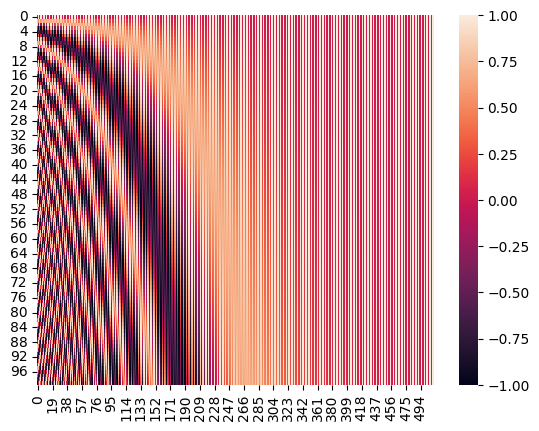

In [30]:
positional_encoding = T.tensor(
    [
        [
            get_positional_encoding_at_indices(
                sequence_position, embedding_index, EMBEDDING_SIZE
            )
            for embedding_index in range(EMBEDDING_SIZE)
        ]
        for sequence_position in range(SEQUENCE_LENGTH)
    ],
    dtype=T.float32,
)

print(f"Positional encoding shape: {positional_encoding.shape}")

sns.heatmap(positional_encoding)

This kind of graph is what we expect to see. Let's see if we can perform the same operations faster with matrix operations.

## Optimizing with matrix operations

We will start with part of the exponent term $2i$:

In [70]:
# Calculate the exponent without scaling by the embedding size
exponent_unscaled = T.repeat_interleave(
    2 * T.arange(0, EMBEDDING_SIZE // 2), 2, output_size=EMBEDDING_SIZE
)

# Print a sample
print(exponent_unscaled[:10])

# Assert that it matches what we have in the function above
for i in range(100):
    exponent_calculated = i - (i % 2)
    assert (
        exponent_unscaled[i] == exponent_calculated
    ), f"matrix operation exponent_unscaled at index {i} is incorrect: {exponent_unscaled[i]!r} != {exponent_calculated!r}"


tensor([0, 0, 2, 2, 4, 4, 6, 6, 8, 8])


Then we can scale this by the embedding size to get the full exponent $2i/d$:

In [71]:
# Calculate the exponent term
exponent = exponent_unscaled / EMBEDDING_SIZE

# Print a sample
print(exponent[:10])

# Assert that it matches what we have in the function above
for i in range(100):
    exponent_calculated = (i - (i % 2)) / EMBEDDING_SIZE
    assert (
        exponent[i] == exponent_calculated
    ), f"matrix operation exponent at index {i} is incorrect: {exponent[i].item()!r} != {exponent_calculated!r}"


tensor([0.0000, 0.0000, 0.0039, 0.0039, 0.0078, 0.0078, 0.0117, 0.0117, 0.0156,
        0.0156])


We can use this to calculate the full phase term $\frac{p}{10000^{2i/d}}$:

In [84]:
# Calculate the phase term
#
# We unsqueeze here so that we get a full matrix of shape
# (sequence_length, embedding_size), not just a vector.
phase = T.arange(SEQUENCE_LENGTH).unsqueeze(1) / 10000**exponent

# Print a sample
print(phase[:10, :10])

# Assert that it matches what we have in the function above (within tolerances)
for sequence_position in range(100):
    for embedding_index in range(100):
        phase_calculated = sequence_position / (
            10000 ** ((embedding_index - (embedding_index % 2)) / EMBEDDING_SIZE)
        )

        assert (
            abs(phase[sequence_position, embedding_index].item() - phase_calculated)
            < 1e-5
        ), f"matrix operation phase at index {sequence_position, embedding_index} is incorrect: {phase[sequence_position, embedding_index].item()!r} != {phase_calculated!r}"

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 1.0000, 0.9647, 0.9647, 0.9306, 0.9306, 0.8977, 0.8977, 0.8660,
         0.8660],
        [2.0000, 2.0000, 1.9293, 1.9293, 1.8611, 1.8611, 1.7954, 1.7954, 1.7319,
         1.7319],
        [3.0000, 3.0000, 2.8940, 2.8940, 2.7917, 2.7917, 2.6931, 2.6931, 2.5979,
         2.5979],
        [4.0000, 4.0000, 3.8586, 3.8586, 3.7223, 3.7223, 3.5907, 3.5907, 3.4639,
         3.4639],
        [5.0000, 5.0000, 4.8233, 4.8233, 4.6529, 4.6529, 4.4884, 4.4884, 4.3298,
         4.3298],
        [6.0000, 6.0000, 5.7880, 5.7880, 5.5834, 5.5834, 5.3861, 5.3861, 5.1958,
         5.1958],
        [7.0000, 7.0000, 6.7526, 6.7526, 6.5140, 6.5140, 6.2838, 6.2838, 6.0618,
         6.0618],
        [8.0000, 8.0000, 7.7173, 7.7173, 7.4446, 7.4446, 7.1815, 7.1815, 6.9277,
         6.9277],
        [9.0000, 9.0000, 8.6820, 8.6820, 8.3751, 8.3751, 8.0792, 8.0792, 7.7937,
         7.7937]])


And lastly we apply either `sin` or `cos` depending on embedding index:

In [89]:
# Calculate encoding
encoding = T.where(T.arange(EMBEDDING_SIZE) % 2 == 0, T.sin(phase), T.cos(phase))

# Print a sample
print(encoding[:10, :10])

# Assert that it matches what we have in the function above (within tolerances)
for sequence_position in range(100):
    for embedding_index in range(100):
        encoding_calculated = get_positional_encoding_at_indices(
            sequence_position, embedding_index, EMBEDDING_SIZE
        )

        assert (
            abs(
                encoding[sequence_position, embedding_index].item()
                - encoding_calculated
            )
            < 1e-5
        ), f"matrix operation embedding at index {sequence_position, embedding_index} is incorrect: {encoding[sequence_position, embedding_index].item()!r} != {encoding_calculated!r}"


tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  8.2186e-01,  5.6969e-01,  8.0196e-01,
          5.9738e-01,  7.8189e-01,  6.2342e-01,  7.6172e-01,  6.4791e-01],
        [ 9.0930e-01, -4.1615e-01,  9.3641e-01, -3.5090e-01,  9.5814e-01,
         -2.8629e-01,  9.7489e-01, -2.2269e-01,  9.8705e-01, -1.6044e-01],
        [ 1.4112e-01, -9.8999e-01,  2.4509e-01, -9.6950e-01,  3.4278e-01,
         -9.3942e-01,  4.3364e-01, -9.0108e-01,  5.1731e-01, -8.5580e-01],
        [-7.5680e-01, -6.5364e-01, -6.5717e-01, -7.5375e-01, -5.4861e-01,
         -8.3608e-01, -4.3421e-01, -9.0081e-01, -3.1672e-01, -9.4852e-01],
        [-9.5892e-01,  2.8366e-01, -9.9385e-01,  1.1069e-01, -9.9823e-01,
         -5.9494e-02, -9.7503e-01, -2.2209e-01, -9.2771e-01, -3.7330e-01],
        [-2.7942e-01,  9.6017e-01, -4.7522e-01,  8.7987e-01, -6.4403e-01,
          7.6500e-01, -7.8150e-0

## Final function

We can put the above calculations together into a function, which will become our final implementation of positional encoding for transformers:

In [93]:
def get_positional_encoding(sequence_length: int, embedding_size: int) -> T.Tensor:
    """
    Calculates a positional encoding matrix per Vaswani et. al. for use in transformers.

    Parameters
    ==========
        sequence_length: int
            The length of the sequence to calculate the positional encoding for.
        embedding_size: int
            The size of the embedding to calculate the positional encoding for.

    Returns
    =======
        A tensor of shape (sequence_length, embedding_size) containing the positional
        encoding matrix for the given sequence length and embedding size.
    """

    assert sequence_length > 0
    assert embedding_size > 1

    exponent = (
        T.repeat_interleave(
            2 * T.arange(0, embedding_size // 2), 2, output_size=embedding_size
        )
        / embedding_size
    )

    assert exponent.shape == (embedding_size,)

    phase = T.arange(sequence_length).unsqueeze(1) / 10000**exponent

    assert phase.shape == (sequence_length, embedding_size)

    encoding = T.where(T.arange(embedding_size) % 2 == 0, T.sin(phase), T.cos(phase))

    assert encoding.shape == (sequence_length, embedding_size)

    return encoding


Let's test it in comparison to our previous solution:

In [94]:
encoding = get_positional_encoding(SEQUENCE_LENGTH, EMBEDDING_SIZE)

# Print a sample
print(get_positional_encoding(SEQUENCE_LENGTH, EMBEDDING_SIZE)[:10, :10])

# Assert that it matches what we have in the function above (within tolerances)
for sequence_position in range(100):
    for embedding_index in range(100):
        encoding_calculated = get_positional_encoding_at_indices(
            sequence_position, embedding_index, EMBEDDING_SIZE
        )

        assert (
            abs(
                encoding[sequence_position, embedding_index].item()
                - encoding_calculated
            )
            < 1e-5
        ), f"get_positional_encoding at index {sequence_position, embedding_index} is incorrect: {encoding[sequence_position, embedding_index].item()!r} != {encoding_calculated!r}"


tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  8.2186e-01,  5.6969e-01,  8.0196e-01,
          5.9738e-01,  7.8189e-01,  6.2342e-01,  7.6172e-01,  6.4791e-01],
        [ 9.0930e-01, -4.1615e-01,  9.3641e-01, -3.5090e-01,  9.5814e-01,
         -2.8629e-01,  9.7489e-01, -2.2269e-01,  9.8705e-01, -1.6044e-01],
        [ 1.4112e-01, -9.8999e-01,  2.4509e-01, -9.6950e-01,  3.4278e-01,
         -9.3942e-01,  4.3364e-01, -9.0108e-01,  5.1731e-01, -8.5580e-01],
        [-7.5680e-01, -6.5364e-01, -6.5717e-01, -7.5375e-01, -5.4861e-01,
         -8.3608e-01, -4.3421e-01, -9.0081e-01, -3.1672e-01, -9.4852e-01],
        [-9.5892e-01,  2.8366e-01, -9.9385e-01,  1.1069e-01, -9.9823e-01,
         -5.9494e-02, -9.7503e-01, -2.2209e-01, -9.2771e-01, -3.7330e-01],
        [-2.7942e-01,  9.6017e-01, -4.7522e-01,  8.7987e-01, -6.4403e-01,
          7.6500e-01, -7.8150e-0

And lastly, let's graph it and see if it visually looks the same:

<Axes: >

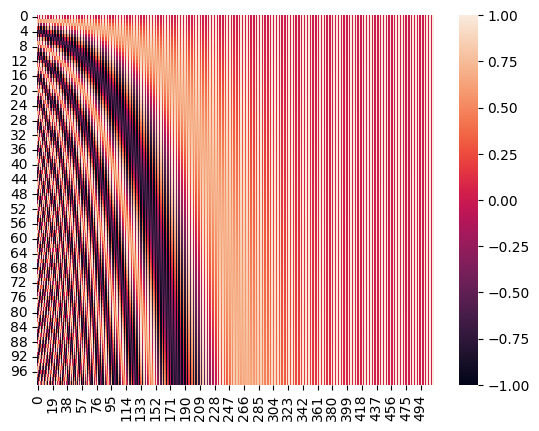

In [95]:
sns.heatmap(encoding)